<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-准备数据" data-toc-modified-id="1-准备数据-1">1 准备数据</a></span><ul class="toc-item"><li><span><a href="#1.1-加载数据" data-toc-modified-id="1.1-加载数据-1.1">1.1 加载数据</a></span></li><li><span><a href="#1.2-将日期列由数字解析为日期" data-toc-modified-id="1.2-将日期列由数字解析为日期-1.2">1.2 将日期列由数字解析为日期</a></span></li><li><span><a href="#1.3-获取label列" data-toc-modified-id="1.3-获取label列-1.3">1.3 获取label列</a></span></li><li><span><a href="#1.4-seasonal_decompose分解" data-toc-modified-id="1.4-seasonal_decompose分解-1.4">1.4 seasonal_decompose分解</a></span><ul class="toc-item"><li><span><a href="#1.4.1-拆解总购买量" data-toc-modified-id="1.4.1-拆解总购买量-1.4.1">1.4.1 拆解总购买量</a></span></li><li><span><a href="#1.4.2-拆解总赎回量" data-toc-modified-id="1.4.2-拆解总赎回量-1.4.2">1.4.2 拆解总赎回量</a></span></li></ul></li></ul></li><li><span><a href="#2-总购买量进行预测" data-toc-modified-id="2-总购买量进行预测-2">2 总购买量进行预测</a></span></li><li><span><a href="#3-对总赎回量进行预测" data-toc-modified-id="3-对总赎回量进行预测-3">3 对总赎回量进行预测</a></span></li><li><span><a href="#4-合并预测结果" data-toc-modified-id="4-合并预测结果-4">4 合并预测结果</a></span></li><li><span><a href="#5-fbprophet-调参-结果对比：" data-toc-modified-id="5-fbprophet-调参-结果对比：-5">5 fbprophet 调参 结果对比：</a></span></li></ul></div>

Action: 资金流入流出预测    
https://tianchi.aliyun.com/competition/entrance/231573/information    
数据集一共包括4张表：用户基本信息数据、用户申购赎回数据、收益率表和银行间拆借利率表    
2.8万用户，284万行为数据，294天拆解利率，427天收益率    
2013-07-01到2014-08-31，预测2014年9月的申购和赎回

In [1]:
import calendar
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from statsmodels import api as sm

from fbprophet import Prophet

from fbprophet.plot import add_changepoints_to_plot

from chinese_calendar import get_holidays, get_holiday_detail

In [2]:
import warnings


warnings.filterwarnings("ignore")


# 1 准备数据
## 1.1 加载数据

In [3]:
user_balance_df = pd.read_csv('user_balance_table.csv')

In [4]:
user_balance_df.head()

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,20140805,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
1,1,20140808,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
2,1,20140811,20397,20395,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
3,1,20140814,20403,20401,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
4,1,20140817,20409,20407,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN


In [5]:
# 除了4个category列，其他列无缺失值
user_balance_df.isna().sum()

user_id                      0
report_date                  0
tBalance                     0
yBalance                     0
total_purchase_amt           0
direct_purchase_amt          0
purchase_bal_amt             0
purchase_bank_amt            0
total_redeem_amt             0
consume_amt                  0
transfer_amt                 0
tftobal_amt                  0
tftocard_amt                 0
share_amt                    0
category1              2666682
category2              2666682
category3              2666682
category4              2666682
dtype: int64

In [6]:
# 昨日余额 + 今日总购买量 - 今日总赎回量
total = user_balance_df['yBalance'] + user_balance_df['total_purchase_amt'] - user_balance_df['total_redeem_amt']

In [7]:
user_balance_df[total != user_balance_df['tBalance']]

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
2234657,9872,20130813,1356954,860592,506227,506183,0,506183,9765,0,9765,9765,0,44,NaN,NaN,NaN,NaN


- 今日余额 = 昨日余额 + 今日申购 - 今日赎回    
(除了2234657行)：tBalance = yBalance + total_purchase_amt - total_consume_amt    

- 今日总购买量 = 直接购买 + 收益    
即：total_purchase_amt = direct_purchase_amt +  share_amt    

- 今日总赎回量 = 消费 + 转出
即：total_redeem_amt = consume_amt + transfer_amt

## 1.2 将日期列由数字解析为日期

In [8]:
user_balance_df['report_date'] = pd.to_datetime(user_balance_df['report_date'], format="%Y%m%d")

In [9]:
user_balance_df['report_date'].min(), user_balance_df['report_date'].max()

(Timestamp('2013-07-01 00:00:00'), Timestamp('2014-08-31 00:00:00'))

## 1.3 获取label列

In [10]:
total_balance = user_balance_df.groupby("report_date")['total_purchase_amt', 'total_redeem_amt'].sum()
total_balance

,total_purchase_amt,total_redeem_amt
report_date,,
2013-07-01,32488348,5525022
2013-07-02,29037390,2554548
2013-07-03,27270770,5953867
2013-07-04,18321185,6410729
2013-07-05,11648749,2763587
...,...,...
2014-08-27,302194801,468164147
2014-08-28,245082751,297893861
2014-08-29,267554713,273756380


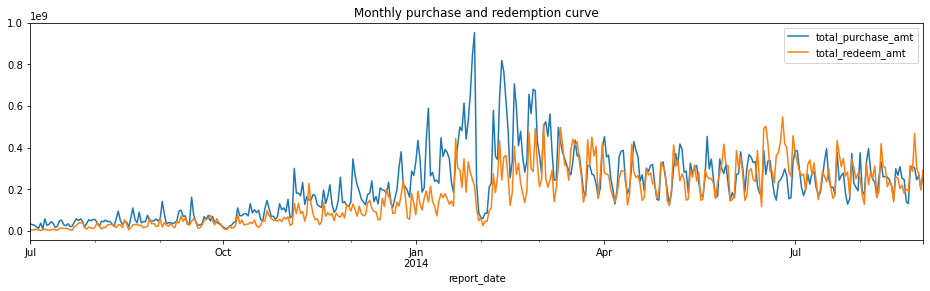

In [11]:
total_balance.plot(figsize=(16, 4), title="Monthly purchase and redemption curve")

In [12]:
# 获得2013-7-1到2014-10-1中国假期的日期
start, end = user_balance_df['report_date'].min(), pd.to_datetime('2014-10-01')

holidays = get_holidays(start=start, end=end, include_weekends=True)

holidays[:3]

[datetime.date(2013, 7, 6),
 datetime.date(2013, 7, 7),
 datetime.date(2013, 7, 13)]

In [13]:
holidays_name = [get_holiday_detail(day)[1] if get_holiday_detail(day)[1] else 'Weekend' for day in holidays ]
holidays_name[:3]

['Weekend', 'Weekend', 'Weekend']

四月之前大部分呈现上升趋势是不平稳序列，四月之后没趋势是平稳序列。

In [14]:
# 保留字段：节假日 holiday 、日期戳 ds、lower_window 以及upper_window
# 将节日看成是一个正态分布，把活动期间当做波峰，lower_window 以及upper_window 的窗口作为扩散
# 国庆和元旦假期肯定休息时间不一致，lower_window 以及upper_window可以理解为假日延长时限，
holiday_df = pd.DataFrame({
    "ds": holidays,
    "holiday": holidays_name,
    "lower_window": -2,
    "upper_window":2
})

In [15]:
purchase = total_balance[['total_purchase_amt']]
redeem = total_balance[['total_redeem_amt']]

In [16]:
redeem.head(2)

,total_redeem_amt
report_date,
2013-07-01,5525022
2013-07-02,2554548


## 1.4 seasonal_decompose分解

In [17]:
# 可视化指定区间内的数据
def plot_stl(data):
    # STL返回3个部分，趋势、季节、残差
    result = sm.tsa.seasonal_decompose(data, period=30)
    fig = result.plot()
    fig.set_figwidth(16)
    fig.set_figheight(8)
    plt.show()
    return result

### 1.4.1 拆解总购买量

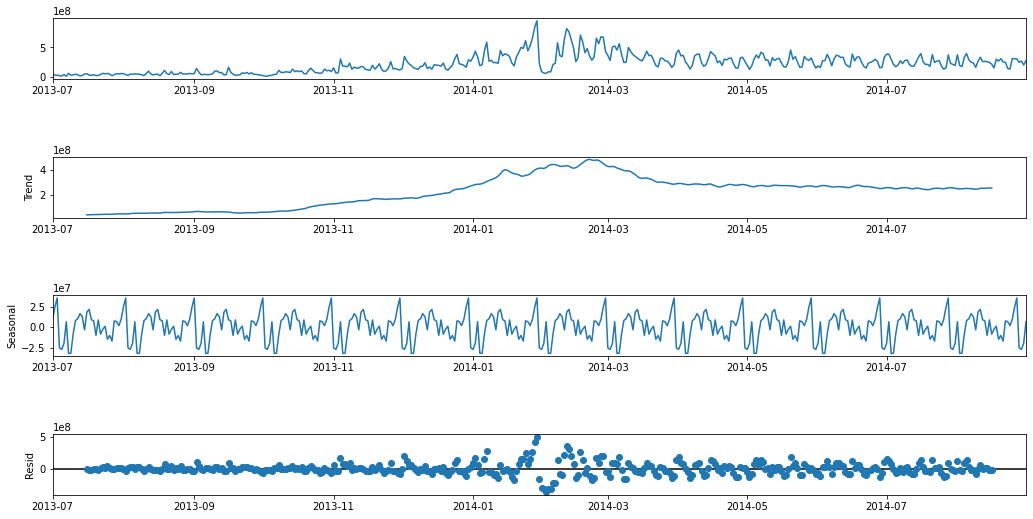

In [18]:
pur_result = plot_stl(purchase)

In [19]:
# purchase[(purchase['ds'] > '2014-08-01') & (purchase['ds'] < '2014-08-31')].set_index('ds').plot(figsize=(16, 4))

### 1.4.2 拆解总赎回量

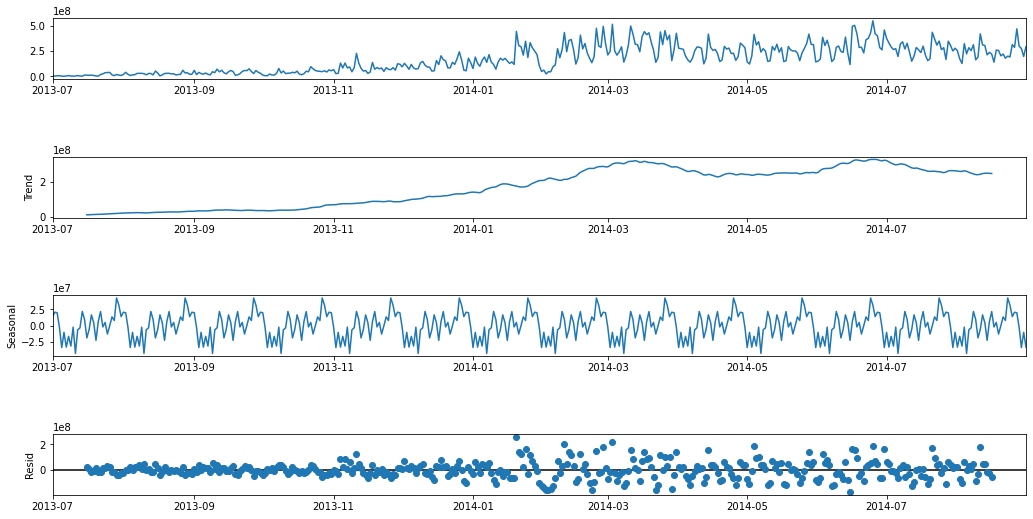

In [20]:
red_result = plot_stl(redeem)

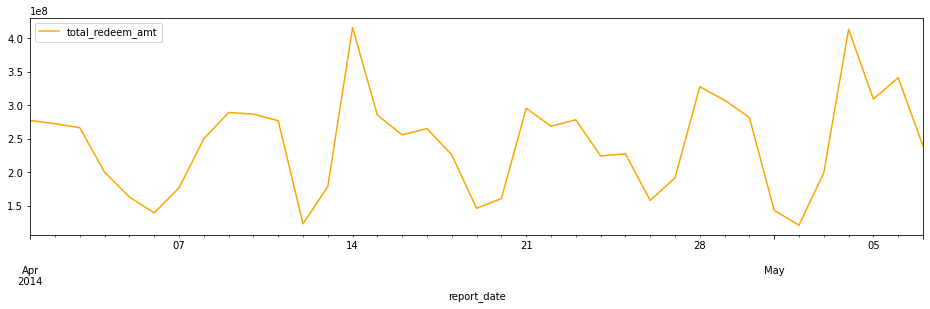

In [21]:
redeem.loc['2014-04-01':'2014-05-07'].plot(figsize=(16, 4), color='orange')

In [22]:
print(calendar.month(2014, 4))

     April 2014
Mo Tu We Th Fr Sa Su
    1  2  3  4  5  6
 7  8  9 10 11 12 13
14 15 16 17 18 19 20
21 22 23 24 25 26 27
28 29 30



赎回量也是在每个周六、周日下降。

# 2 总购买量进行预测

In [23]:
# 调整数据集为保留字段格式
purchase['ds'] = purchase.index
purchase.columns = ['y', 'ds']
purchase.head()

,y,ds
report_date,,
2013-07-01,32488348,2013-07-01
2013-07-02,29037390,2013-07-02
2013-07-03,27270770,2013-07-03
2013-07-04,18321185,2013-07-04
2013-07-05,11648749,2013-07-05


In [24]:
purchase = purchase.reset_index(drop=True)

In [25]:
purchase.head(2)

,y,ds
0,32488348,2013-07-01
1,29037390,2013-07-02


In [26]:
model = Prophet(
    holidays=holiday_df,
    weekly_seasonality=True,
    seasonality_prior_scale=10,  # 用来控制季节项的灵活度
    n_changepoints=300,  # 突变点个数
    changepoint_prior_scale=0.5
).fit(purchase)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [27]:
# 将未来的日期扩展指定的天数，得到一个数据框
future = model.make_future_dataframe(periods=30)

In [28]:
purchase_fcst = model.predict(future)
purchase_fcst.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Dragon Boat Festival,Dragon Boat Festival_lower,Dragon Boat Festival_upper,Labour Day,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-07-01,3.979651e+07,-2.529033e+07,1.298555e+08,3.979651e+07,3.979651e+07,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.718555e+07,1.718555e+07,1.718555e+07,0.0,0.0,0.0,5.698206e+07
1,2013-07-02,4.035801e+07,1.098020e+05,1.505325e+08,4.035801e+07,4.035801e+07,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.390838e+07,3.390838e+07,3.390838e+07,0.0,0.0,0.0,7.426639e+07


In [29]:
purchase_fcst.iloc[-30:].yhat.describe()

count    3.000000e+01
mean     2.398680e+08
std      5.124826e+07
min      1.422087e+08
25%      2.155667e+08
50%      2.568477e+08
75%      2.845477e+08
max      3.261752e+08
Name: yhat, dtype: float64

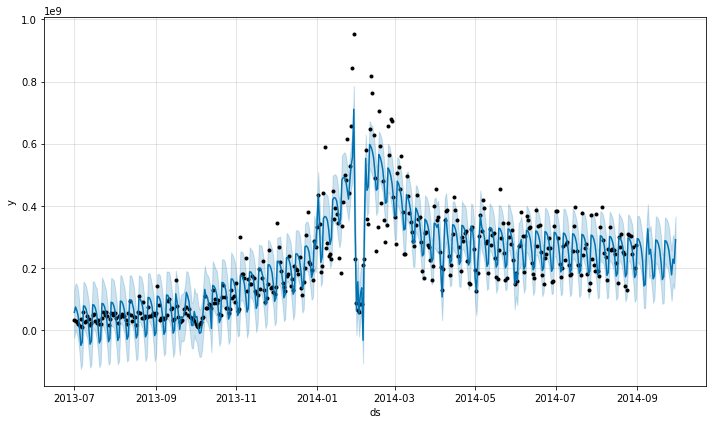

In [30]:
fig = model.plot(purchase_fcst)

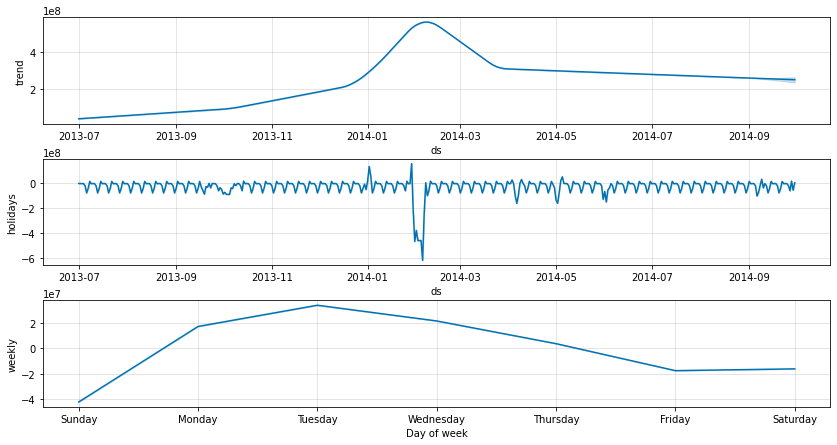

In [31]:
fig = model.plot_components(purchase_fcst)
fig.set_figheight(6)
fig.set_figwidth(12)
plt.show()

In [32]:
# purchase2 = purchase_fcst[(purchase_fcst['ds'] >= '2014-09-01') & (purchase_fcst['ds'] <= '2014-09-30')]

In [33]:
purchase2 = purchase_fcst.iloc[-30:]
purchase2.shape

(30, 43)

# 3 对总赎回量进行预测

In [34]:
# 调整数据集为保留字段格式
redeem['ds'] = redeem.index
redeem.columns = ['y', 'ds']
redeem.head()

,y,ds
report_date,,
2013-07-01,5525022,2013-07-01
2013-07-02,2554548,2013-07-02
2013-07-03,5953867,2013-07-03
2013-07-04,6410729,2013-07-04
2013-07-05,2763587,2013-07-05


In [35]:
holiday_df.columns

Index(['ds', 'holiday', 'lower_window', 'upper_window'], dtype='object')

In [36]:
model2 = Prophet(
    holidays=holiday_df,
    weekly_seasonality=True,
    seasonality_prior_scale=10,  # 用来控制季节项的灵活度
    n_changepoints=300,  # 突变点个数
    changepoint_prior_scale=0.5)

In [37]:
# model2.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)
model2 = model2.fit(redeem)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [38]:
fcst = model2.make_future_dataframe(periods=30)
redeem_fcst = model2.predict(fcst)
redeem_fcst.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Dragon Boat Festival,Dragon Boat Festival_lower,Dragon Boat Festival_upper,Labour Day,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-07-01,4.315339e+07,-1.304915e+07,1.247499e+08,4.315339e+07,4.315339e+07,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.540642e+07,1.540642e+07,1.540642e+07,0.0,0.0,0.0,5.855982e+07
1,2013-07-02,4.356846e+07,-3.918842e+07,9.911493e+07,4.356846e+07,4.356846e+07,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-9.837503e+06,-9.837503e+06,-9.837503e+06,0.0,0.0,0.0,3.373096e+07


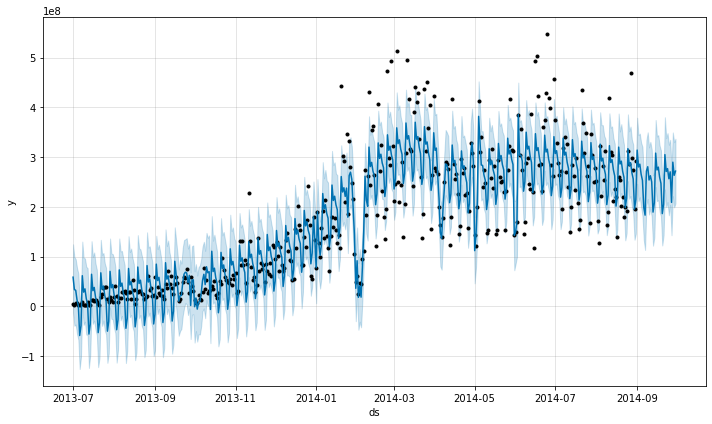

In [39]:
fig = model2.plot(redeem_fcst)
plt.show()

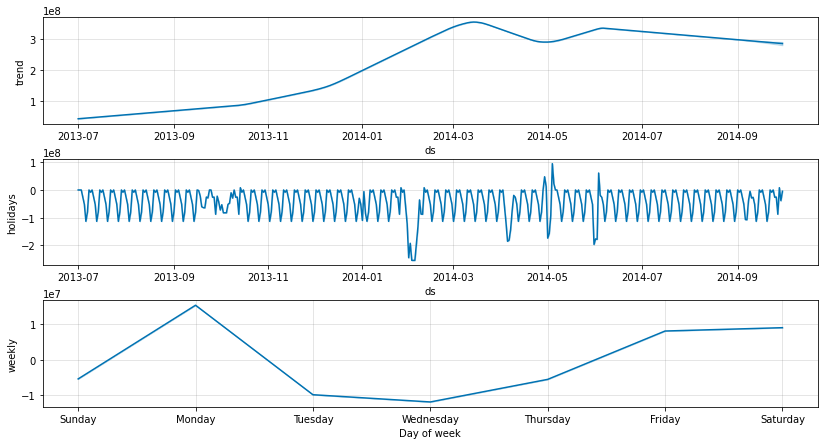

In [40]:
fig = model2.plot_components(redeem_fcst)
fig.set_figheight(6)
fig.set_figwidth(12)
plt.show()

In [41]:
redeem2 = redeem_fcst[(redeem_fcst['ds'] >= '2014-09-01') & (redeem_fcst['ds'] <= '2014-09-30')]

In [42]:
redeem2.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Dragon Boat Festival,Dragon Boat Festival_lower,Dragon Boat Festival_upper,Labour Day,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
427,2014-09-01,2.986016e+08,2.465459e+08,3.792859e+08,2.985806e+08,2.986229e+08,0.0,0.0,0.0,0.0,...,3.671595e+04,3.671595e+04,3.671595e+04,1.540642e+07,1.540642e+07,1.540642e+07,0.0,0.0,0.0,3.140447e+08
428,2014-09-02,2.981721e+08,2.112455e+08,3.440534e+08,2.980967e+08,2.982479e+08,0.0,0.0,0.0,0.0,...,-8.166684e+06,-8.166684e+06,-8.166684e+06,-9.837503e+06,-9.837503e+06,-9.837503e+06,0.0,0.0,0.0,2.801679e+08


In [43]:
redeem2.shape

(30, 43)

# 4 合并预测结果

In [44]:
purchase2['ds'].head()

427   2014-09-01
428   2014-09-02
429   2014-09-03
430   2014-09-04
431   2014-09-05
Name: ds, dtype: datetime64[ns]

In [45]:
 # 两行代码效果等价
# purchase2['ds'].apply(lambda x: str(x).replace('-', '')[:8])
purchase2['ds'].dt.strftime("%Y%m%d")[:5]

427    20140901
428    20140902
429    20140903
430    20140904
431    20140905
Name: ds, dtype: object

In [46]:
result = pd.DataFrame({'report_date': purchase2['ds'].dt.strftime("%Y%m%d"), 
                       'purchase': purchase2['yhat'],
                       'redeem':redeem2['yhat']
                      })

In [47]:
result.to_csv("tc_comp_predict_table.csv", header=None, index=False)

In [48]:
result.head(2)

,report_date,purchase,redeem
427,20140901,2.945559e+08,3.140447e+08
428,20140902,2.922510e+08,2.801679e+08


In [49]:
result.describe()

,purchase,redeem
count,3.000000e+01,3.000000e+01
mean,2.398680e+08,2.557426e+08
std,5.124826e+07,3.676303e+07
min,1.422087e+08,1.832751e+08
25%,2.155667e+08,2.479270e+08
50%,2.568477e+08,2.644601e+08
75%,2.845477e+08,2.790956e+08
max,3.261752e+08,3.140447e+08


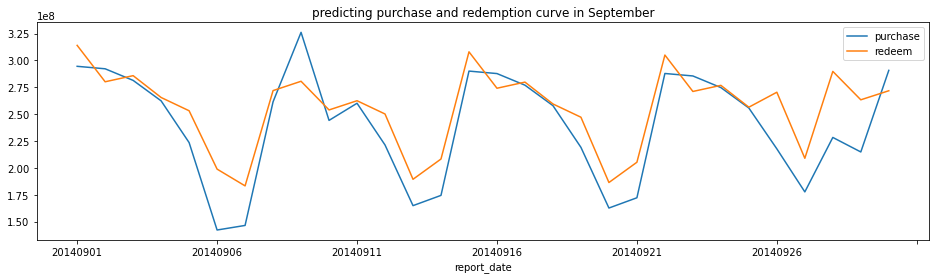

In [50]:
result.set_index('report_date').plot(figsize=(16, 4), title="predicting purchase and redemption curve in September")

In [54]:
print(calendar.month(2014, 9))

   September 2014
Mo Tu We Th Fr Sa Su
 1  2  3  4  5  6  7
 8  9 10 11 12 13 14
15 16 17 18 19 20 21
22 23 24 25 26 27 28
29 30



# 5 fbprophet 调参 结果对比：

老师提交的prophet预测成绩为76.7764     
我增加了假日，但最开始预测成绩为76.3688